# Get data

In [134]:
from astropy.io import ascii

data = ascii.read('data.dat')

In [4]:
data = data.to_pandas()

In [5]:
data['classification'] = data[['quasar', 'galaxy', 'star']].idxmax(axis=1, skipna = True)

In [136]:
data

SOURCE_ID,random_index,ra,dec,b,parallax,pm,phot_g_mean_mag,bp_g,g_rp,astrometric_chi2_al,astrometric_n_good_obs_al,phot_g_n_obs,phot_g_mean_flux_over_error,quasar,galaxy,star
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64
1265515347877933440,10075,222.2748877964174,22.198160757624645,62.88185687555298,-0.33668980134029775,0.7173172831535339,17.93385887145996,-2.318182945251465,3.621396064758301,2874.529296875,557,540,134.34176635742188,2.2420622650121125e-11,1.0,1.0961916097063096e-10
5361196917262946432,15072,162.2255880878679,-49.75239367222261,8.437575826696916,-0.03670704081825209,5.728017807006836,19.84228515625,-2.758350372314453,4.355935096740723,163.85496520996094,119,103,77.4830093383789,9.393034960947233e-12,0.9991883039474487,0.0008117138058878481
1232222032709253760,21887,214.14998079670747,16.513552038185832,67.61610494550179,1.771743674736804,2.9129526615142822,20.476003646850586,-1.0306758880615234,2.346782684326172,500.0566101074219,211,261,91.17527770996094,2.1405439838417806e-05,0.9999387860298157,3.978026143158786e-05
1508859364417098624,48386,210.6647188658992,46.20634448793206,66.28707227872079,-0.2998018859774316,0.6104444265365601,18.904287338256836,-1.6984519958496094,2.9888057708740234,1701.7203369140625,393,523,102.93529510498047,6.760222959201201e-08,0.9999998807907104,2.4985817859146664e-08
1253126291374182656,54587,215.17304544205666,23.28879425028681,69.47886314381957,2.060774528752372,1.5780792236328125,20.626930236816406,-0.9972190856933594,2.4398326873779297,862.2040405273438,228,230,67.85320281982422,0.00013327253691386431,0.9997066855430603,0.000160043899086304
6412316770552882048,58708,328.99726131069883,-57.745577203863824,-46.725313011611185,0.7742238830480377,2.344511032104492,20.316659927368164,-1.1405315399169922,2.5691051483154297,839.3004150390625,251,253,105.85601806640625,0.00016996324120555073,0.9996805787086487,0.00014945620205253363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6054116360632415616,208985,183.64668244850972,-63.83972337412898,-1.258031567463955,2.429400232862029,15.98626708984375,20.605308532714844,-0.36971473693847656,1.2480640411376953,387.6643371582031,304,332,155.150634765625,8.936248185875684e-09,1.7255350030609407e-05,0.9999827146530151
4057060192664517120,208986,265.7208872962649,-29.663932924442584,0.12730628885208517,0.6024844376885808,1.8483023643493652,17.207538604736328,1.0077438354492188,0.9821949005126953,465.75384521484375,446,434,1560.777099609375,3.131924786788781e-13,4.317691603555884e-12,1.0


/home/tinmai/anaconda3/envs/tin/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/tinmai/anaconda3/envs/tin/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


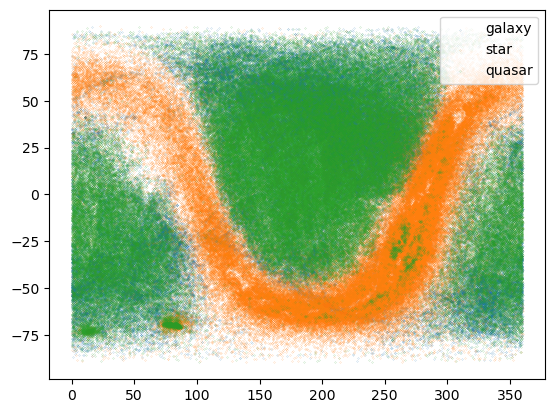

In [22]:
import matplotlib.pyplot as plt

for i in ['galaxy','star','quasar']:
    plt.scatter(data[data['classification'] == i]['ra'], data[data['classification'] == i]['dec'], s = 0.01, label = i)

plt.legend()

In [23]:
data['classification'].value_counts()

classification
galaxy    150000
quasar    150000
star      150000
Name: count, dtype: int64

In [6]:
import numpy as np

data['sinb'] = np.sin(data['b'])
data['uwe'] = np.sqrt(data['astrometric_chi2_al']/(data['astrometric_n_good_obs_al'] - 5))
data['relvarg'] = np.sqrt(data['phot_g_n_obs']/data['phot_g_mean_flux_over_error'])

In [131]:
data['sinb']

0         0.049983
1         0.834488
2        -0.997419
3        -0.308510
4         0.355851
            ...   
449995   -0.779287
449996    0.084526
449997   -0.217475
449998   -0.690644
449999   -0.194604
Name: sinb, Length: 450000, dtype: float64

# Gaussian Mixture Model

In [126]:
features_name = ['sinb','uwe','parallax','pm','phot_g_mean_mag','bp_g','g_rp','relvarg']
features = data[features_name]
label = data['classification']

In [127]:
features.values.shape

(450000, 8)

In [137]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler().fit(features)
scaled_features=scaler.transform(features)
feature_names = scaler.feature_names_in_

In [138]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

# Split data into training and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(scaled_features, label, test_size=0.5, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.5, random_state=42)


In [139]:
X_train_val.shape, X_train.shape, X_val.shape

((225000, 8), (112500, 8), (112500, 8))

In [140]:
y_train.value_counts()

classification
galaxy    37613
star      37569
quasar    37318
Name: count, dtype: int64

In [47]:
from GMMClassifier import GMMClassifier

gmm = GMMClassifier()


In [141]:
from sklearn.utils.estimator_checks import check_estimator

# check_estimator(GMMClassifier()) 

[Text(0.5, 0, 'Number of components'),
 Text(0, 0.5, 'Cross entropy loss'),
 Text(0.5, 1.0, 'Validation Curve for GMMClassifier')]

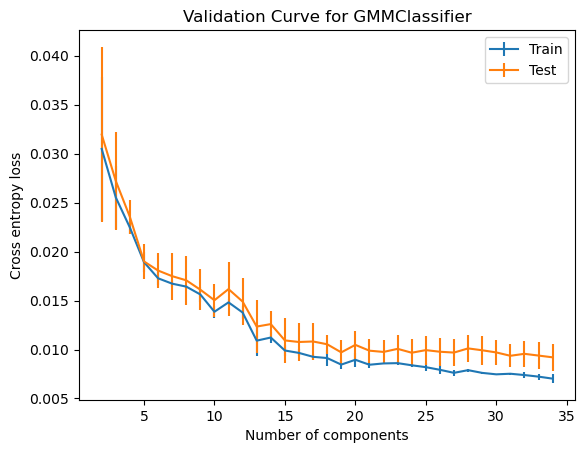

In [49]:
from sklearn.model_selection import ValidationCurveDisplay

# Create an instance of your GMMClassifier
gmm = GMMClassifier(covariance_type='full', random_state=42)

# Define the range for n_components
n_comp = np.arange(2, 35)

disp = ValidationCurveDisplay.from_estimator(
    gmm,
    X_train,  # your training features
    y_train,  # your training labels
    param_name="n_components",
    param_range=n_comp,
    cv=3,
    scoring='neg_log_loss',
    negate_score=True,
    std_display_style="errorbar",
    n_jobs=4,
)
disp.ax_.set(
    xlabel="Number of components",
    ylabel="Cross entropy loss",
    title="Validation Curve for GMMClassifier",
)


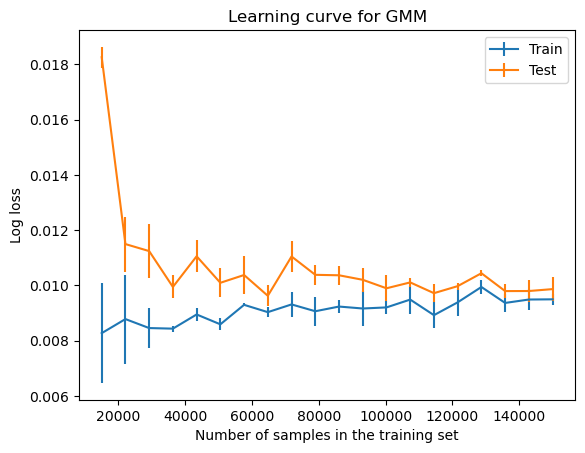

In [29]:
from sklearn.model_selection import LearningCurveDisplay

display = LearningCurveDisplay.from_estimator(
    GMMClassifier(n_components = 18, covariance_type='full', random_state=42),
    X_train_val,
    y_train_val,
    train_sizes=np.linspace(0.1,1,num = 20),
    cv=3,
    scoring = 'neg_log_loss',
    negate_score=True,  # to use when metric starts with "neg_"
    std_display_style="errorbar",
    n_jobs=2,
)
_ = display.ax_.set(title="Learning curve for GMM")

In [86]:
classifier = GMMClassifier(n_components=18, covariance_type='full', random_state=42)

In [87]:
from sklearn.model_selection import cross_val_score

val_score = cross_val_score(classifier, X_train_val, y_train_val, cv=3, n_jobs=2)
print(
    "The mean score using nested cross-validation is: "
    f"{val_score.mean():.3f} ± {val_score.std():.3f}"
)

The mean score using nested cross-validation is: 0.997 ± 0.000


In [88]:
classifier = GMMClassifier(n_components=18)
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_val)


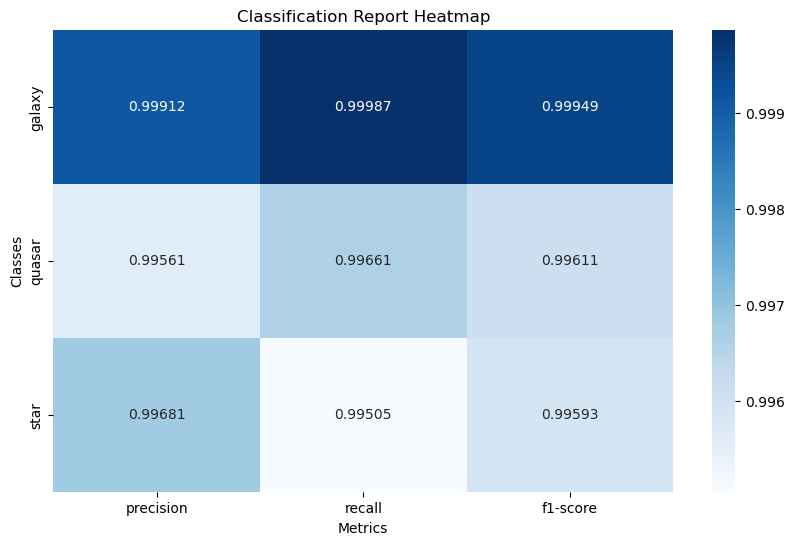

In [89]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the classification report as a dictionary
report_dict = classification_report(y_val, y_pred, output_dict=True)

# Convert the dictionary to a Pandas DataFrame for easier plotting
report_df = report_df.drop(labels=["accuracy", "macro avg", "weighted avg"], errors="ignore")

plt.figure(figsize=(10, 6))
sns.heatmap(report_df, annot=True, cmap="Blues", fmt=".5f")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.title("Classification Report Heatmap")
plt.show()

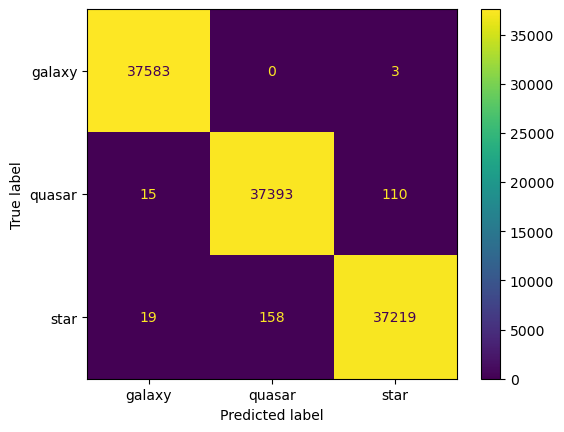

In [90]:
cm = confusion_matrix(y_val, y_pred, labels=classifier.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classifier.classes_)

disp.plot()

# Feature selection

In [91]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [95]:
from sklearn.pipeline import make_pipeline

model_without_selection = GMMClassifier(n_components=18, covariance_type='full', random_state=42)
model_with_selection = make_pipeline(
    SelectKBest(score_func=f_classif, k=2),
    GMMClassifier(n_components=18, covariance_type='full', random_state=42)
)

In [97]:
from sklearn.model_selection import cross_validate

cv_results_without_selection = cross_validate(
    model_without_selection, X_train, y_train, cv = 3
)
cv_results_without_selection = pd.DataFrame(cv_results_without_selection)


In [99]:
cv_results_with_selection = cross_validate(
    model_with_selection, X_train, y_train, return_estimator=True, cv = 3
)
cv_results_with_selection = pd.DataFrame(cv_results_with_selection)

In [100]:
cv_results = pd.concat(
    [cv_results_without_selection, cv_results_with_selection],
    axis=1,
    keys=["Without feature selection", "With feature selection"],
)
# swap the level of the multi-index of the columns
cv_results = cv_results.swaplevel(axis="columns")

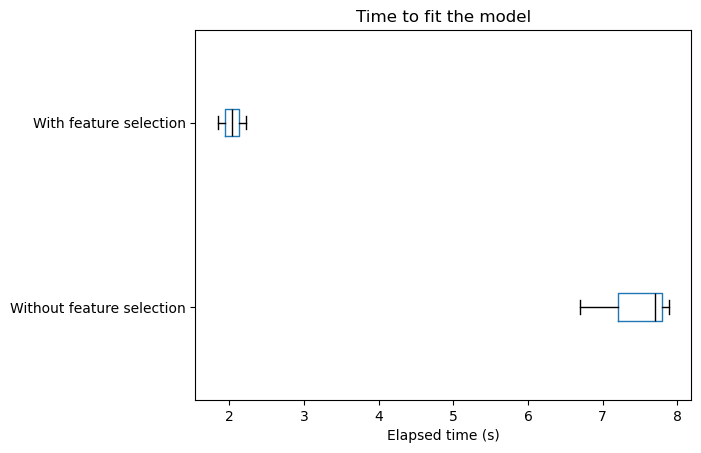

In [101]:
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
cv_results["fit_time"].plot.box(color=color, vert=False)
plt.xlabel("Elapsed time (s)")
_ = plt.title("Time to fit the model")

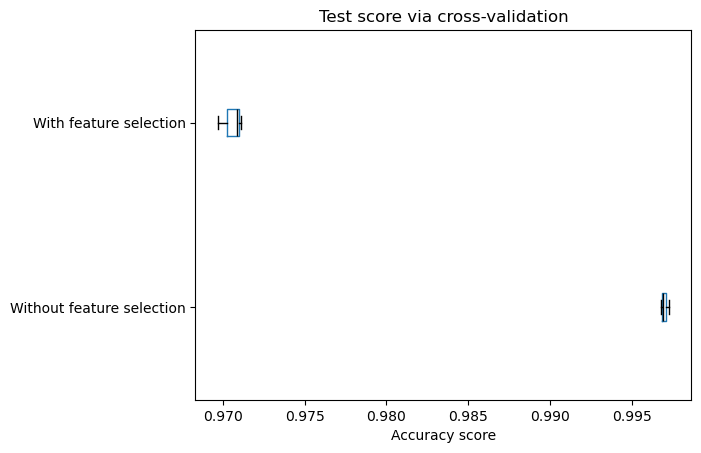

In [102]:
cv_results["test_score"].plot.box(color=color, vert=False)
plt.xlabel("Accuracy score")
_ = plt.title("Test score via cross-validation")

# Features importance

In [132]:
from sklearn.inspection import permutation_importance

def plot_feature_importances(perm_importance_result, feat_name):
    """bar plot the feature importance"""

    fig, ax = plt.subplots()

    indices = perm_importance_result["importances_mean"].argsort()
    plt.barh(
        range(len(indices)),
        perm_importance_result["importances_mean"][indices],
        xerr=perm_importance_result["importances_std"][indices],
    )

    ax.set_yticks(range(len(indices)))
    _ = ax.set_yticklabels(feat_name[indices])
    ax.set_title("Permutation Importances on selected subset of features\n(test set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()


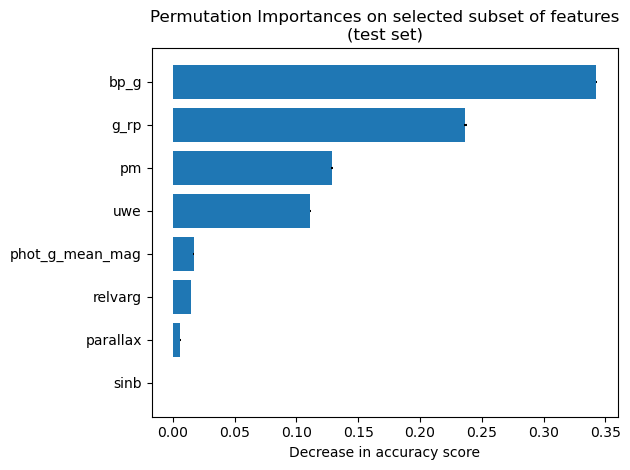

In [133]:
model = GMMClassifier(n_components=18, covariance_type='full', random_state=42)
model.fit(X_train, y_train)

perm_importance_result_train = permutation_importance(
    model, X_train, y_train, n_repeats=10, random_state=42
)

plot_feature_importances(perm_importance_result_train, feature_names)